In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
sns.set_style('whitegrid')
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tools.eval_measures import aic
from statsmodels.tsa.arima_model import ARIMAResults
from datetime import datetime
import itertools
import warnings
warnings.filterwarnings('ignore')
from mypackage import *

In [2]:
df = pd.read_excel("training.xlsx")
df = df.set_index("Date")

**VISIAL EVALUATION OF THE SERIES**

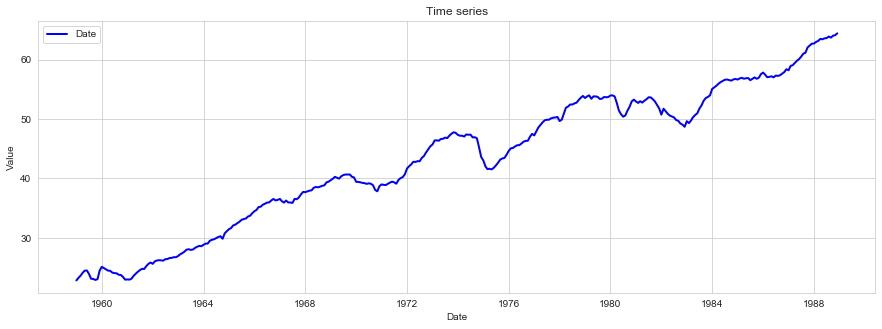

In [3]:
plot_series(df)

**ROLLING MEAN**

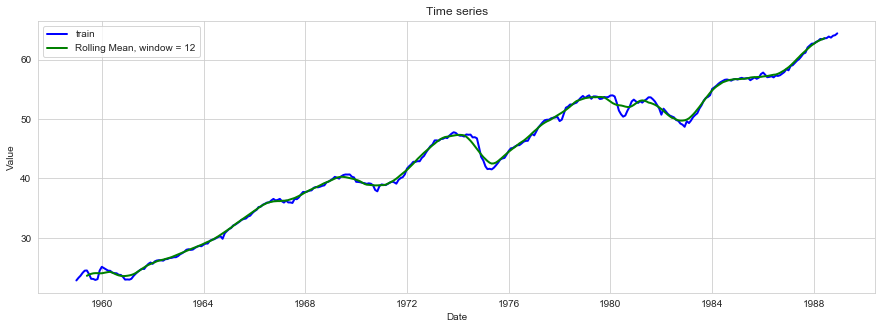

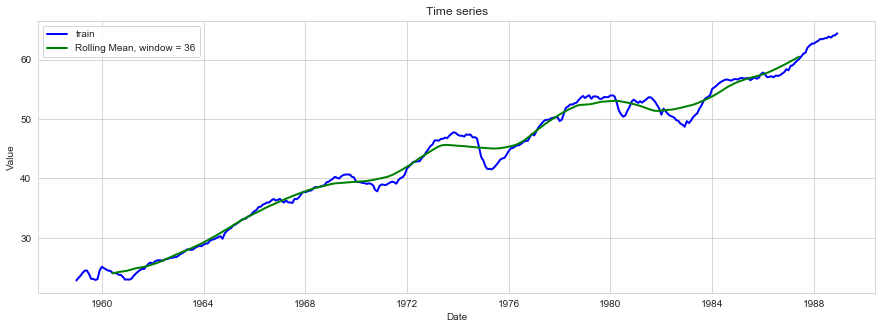

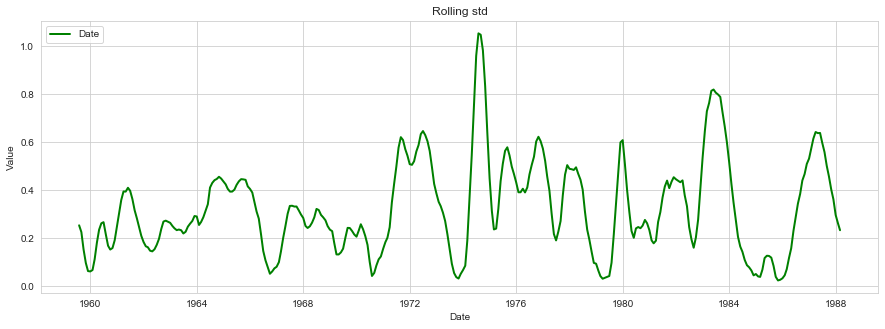

In [4]:
for i in range(12, 37, 24):
    plt.figure(figsize=(15,5))
    plt.plot(df, color='blue', label='train', linewidth=2, markersize=15)
    label = 'Rolling Mean, window = 12' if i == 12 else 'Rolling Mean, window = 36'
    plt.plot(rolling_mean(df, i)['Value'], color='green', label=label, linewidth=2, markersize=15)
    plt.legend(loc='upper left')
    plt.title('Time series')
    plt.xlabel('Date')
    plt.ylabel('Value')
    plt.show()

plot_series(rolling_std(df, 12), color='green', title='Rolling std')

ВЫВОД: Временной ряд не является стационарным, так как его математическое ожидание и дисперсия зависят от времени

**DECOMPOSING**


**ADDITIVE MODEL**

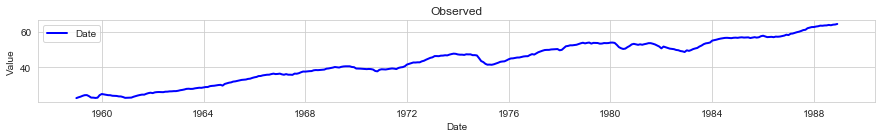

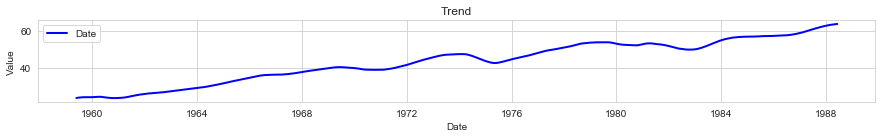

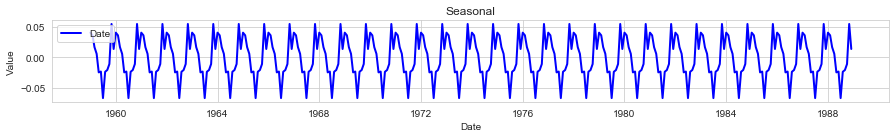

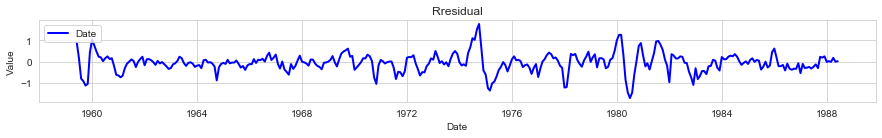

In [5]:
obs, tren, seas, resid = seasonal_decompose(df)
plot_series(obs, x=15, y=1.5, title='Observed')
plot_series(tren, x=15, y=1.5, title='Trend')
plot_series(seas, x=15, y=1.5, title='Seasonal')
plot_series(resid, x=15, y=1.5, title='Rresidual')

**MULTIPLICATIVE MODEL**

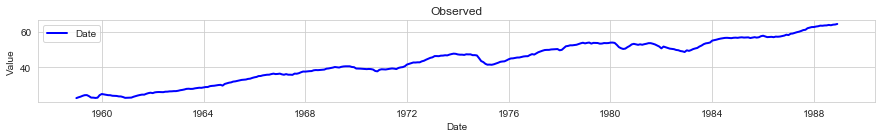

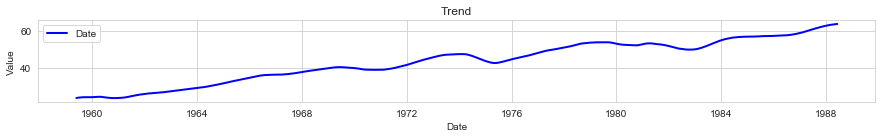

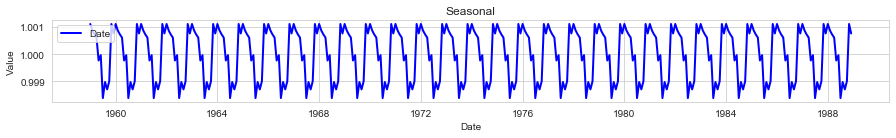

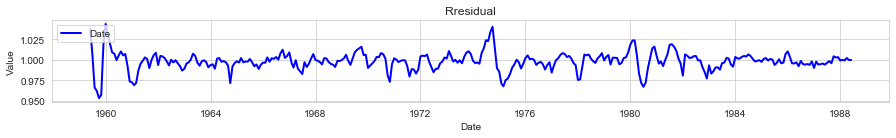

In [6]:
obs, tren, seas, resid = seasonal_decompose(df, model='multiplicative')
plot_series(obs, x=15, y=1.5, title='Observed')
plot_series(tren, x=15, y=1.5, title='Trend')
plot_series(seas, x=15, y=1.5, title='Seasonal')
plot_series(resid, x=15, y=1.5, title='Rresidual')

**MODEL PARAMETRS SELECTION**

Differencing to make time series stationary

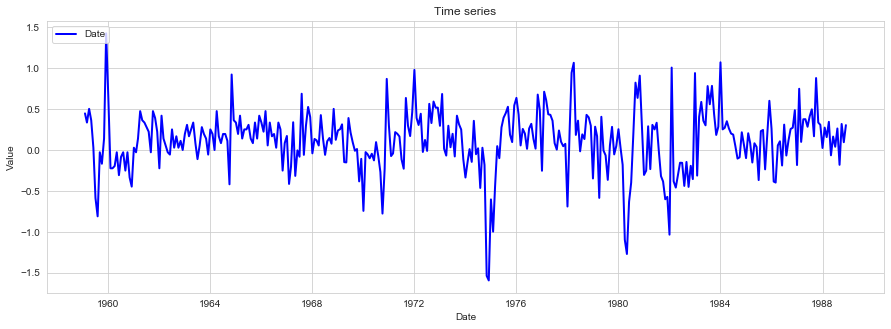

In [7]:
df_diff = df.copy()
df_diff["Value"] = df["Value"].diff(periods=1)
df_diff = df_diff.dropna()
plot_series(df_diff)

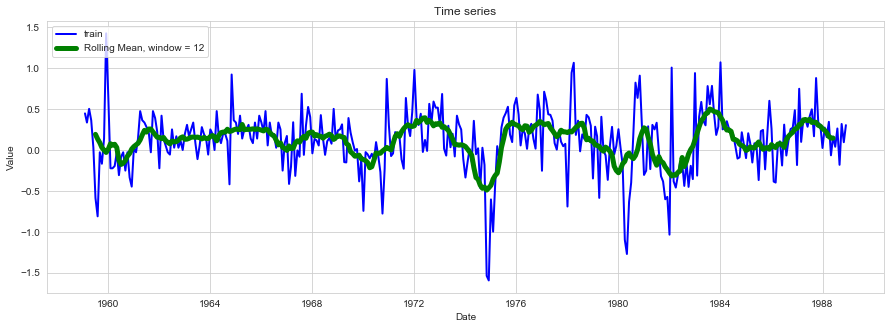

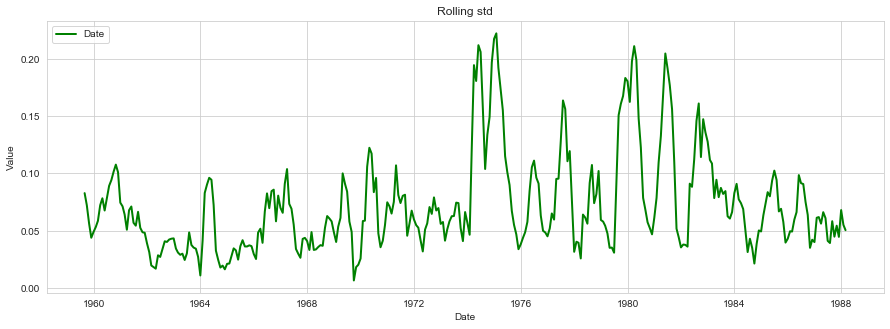

In [8]:
plt.figure(figsize=(15,5))
plt.plot(df_diff, color='blue', label='train', linewidth=2, markersize=15)
plt.plot(rolling_mean(df_diff, 12)['Value'], color ='green', label='Rolling Mean, window = 12', linewidth=5, markersize=15)
plt.legend(loc='upper left')
plt.title('Time series')
plt.xlabel('Date')
plt.ylabel('Value')
plt.show()
plot_series(rolling_std(df_diff, 12), color='green', title='Rolling std')

Продифференцированный ряд является стационарным. Определен параметр для ARIMA(p,d,q) : d = 1

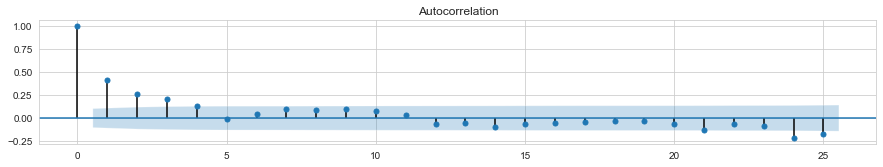

In [9]:
# q = 3 - номер последнего несезонного лага, при котором автокорреляция значима
fig = plt.figure(figsize=(15,5))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(df_diff, lags=25, ax=ax1)

ARIMA(p,d,q) : q = 3 - номер последнего несезонного лага, при котором автокорреляция значима.

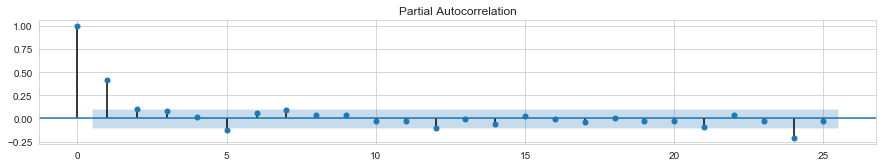

In [10]:
fig = plt.figure(figsize=(15,5))
ax1 = fig.add_subplot(212)
figp = sm.graphics.tsa.plot_pacf(df_diff, lags=25, ax=ax1)

ARIMA(p,d,q) : p = 1 - номер последнего несезонного лага, при котором частичная автокорреляция значима

In [11]:
def R2_score(y_true, y_pred) -> float:
    #проверка на совпдение типов у передаваемых значений
    assert y_true.shape == y_pred.shape, 'Error, change size'
    SSres = np.sum(np.power(y_true - y_pred,2))
    #среднее арифмитическое
    mean_y_true = np.mean(y_true)
    SStot = np.sum(np.power (y_true - mean_y_true,2))
    return 1 - SSres / SStot

def AIC(llf, k):
    return -2 * llf + 2 * (k + 1)

In [12]:
def keyFunc(item):
    return item[1]

Используя метод "поиск по сетке", найдем другие возможные параметры p и q

In [13]:
n = 10
p = q = range(0, n)
d = 1
#сгенирируем различные комбинации
pq = list(itertools.product(p, q))
models = {}
for i in range(0, len(pq)):
    try:
        model = sm.tsa.ARIMA(df, order=(pq[i][0], 1, pq[i][1])).fit(disp=0)
        models[(pq[i][0], 1, pq[i][1])] = AIC(model.llf, pq[i][0] + 1 + pq[i][1])
    except:
        continue
models = sorted(models.items(), key=keyFunc)
# Выделим топ 3 на по критерию Акаике
print(models[:3])   

[((9, 1, 4), 241.22248892236553), ((8, 1, 6), 242.72818898166133), ((8, 1, 2), 243.3907058457595)]


**TRAINING**

Сравним прогнозируемые данные с реальными значениями временного ряда, чтобы  оценить точность прогнозов.

In [14]:
def predict(parametr):
    test = pd.read_excel("testing.xlsx").set_index('Date')
    model = sm.tsa.ARIMA(df, order=parametr).fit(disp=0)
    test_pred = model.predict('1988-12-1','1993-12-1', typ='levels')
    test['Value_pred'] = test_pred
    return test

Model 1 :  (1, 1, 3)
R^2: -3.32
AIC:  228.25095492221317


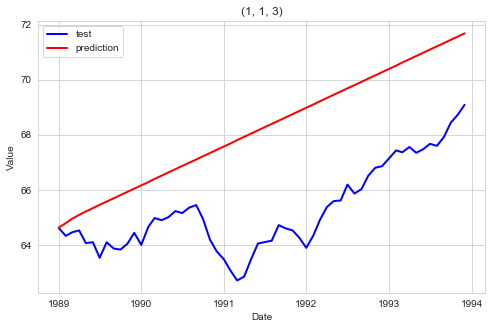

Model 2 :  (8, 1, 6)
R^2: -3.14
AIC:  248.25095492221317


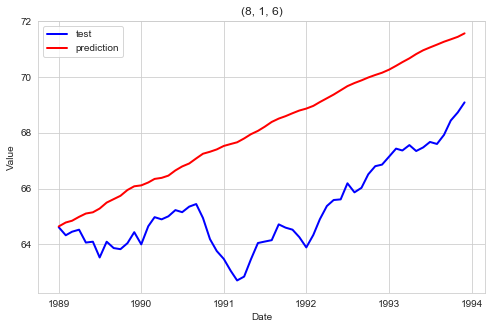

Model 3 :  (8, 1, 2)
R^2: -3.78
AIC:  240.25095492221317


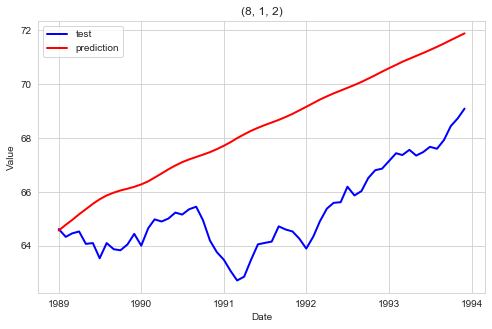

Model 4 :  (9, 1, 4)
R^2: -4.02
AIC:  246.25095492221317


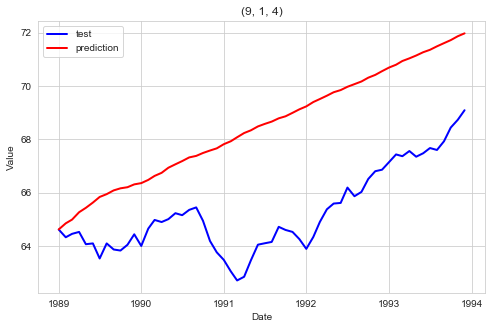

In [15]:
parametr=[(1,1,3),(8,1,6), (8,1,2), (9,1,4)]
for i in range(len(parametr)):
    test = predict(parametr[i])
    plt.figure(figsize=(8,5))
    plt.plot(test['Value'], color='blue', label='test', linewidth=2, markersize=15)
    plt.plot(test['Value_pred'], color='red', label='prediction', linewidth=2, markersize=15)
    plt.legend(loc='upper left')
    plt.title(parametr[i])
    plt.xlabel('Date')
    plt.ylabel('Value')
    r2 = R2_score(test['Value'], test['Value_pred'])
    print('Model', i + 1, ': ', parametr[i])
    print('R^2: %1.2f' % r2)
    print( 'AIC: ', AIC(model.llf, parametr[i][0]+parametr[i][1]+parametr[i][2]))
    plt.show()

Проанализировав коэффициент детерминации r2_score, пришли к выводу: model 2 обладает наибольшей точностью.

**PREDICTION**

Выбрали наилучшую модель - ARIMA(8,1,6)

R^2: -3.14
AIC:  242.72818898166133


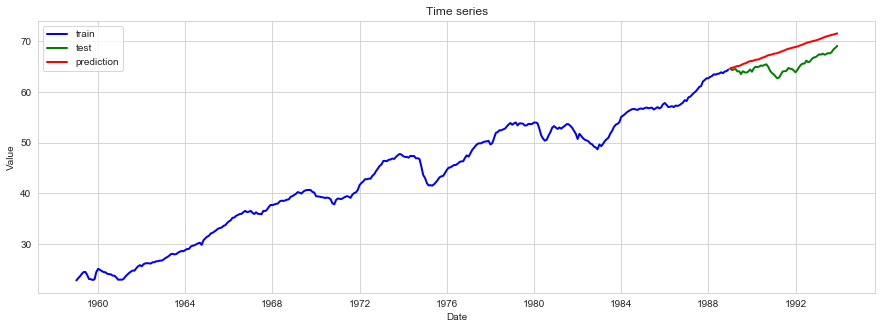

In [16]:
test = pd.read_excel("testing.xlsx").set_index('Date')
model = sm.tsa.ARIMA(df, order=(8,1,6)).fit(disp=0)
test_pred = model.predict('1988-12-1','1993-12-1', typ='levels')
test['Value_pred'] = test_pred
plt.figure(figsize=(15,5))
plt.plot(df, color='blue', label='train', linewidth=2, markersize=15)
plt.plot(test['Value'], color='green', label='test', linewidth=2, markersize=15)
plt.plot(test['Value_pred'], color='red', label='prediction', linewidth=2, markersize=15)
plt.legend(loc='upper left')
plt.title('Time series')
plt.xlabel('Date')
plt.ylabel('Value')
r2 = R2_score(test['Value'], test['Value_pred'])
print('R^2: %1.2f' % r2)
print('AIC: ', AIC(model.llf, 15))
plt.show()